# HATS-7

In [1]:
import lightkurve as lk
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [2]:
name = 'HATS-7'

In [3]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))

In [4]:
obs = om.Observation.from_files(fnames, force=True)

In [5]:
obs

HATS-7 [2 Visits]

In [6]:
clc = lk.search_lightcurve(name, author='SPOC', exptime=120).download_all().stitch().remove_nans()
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

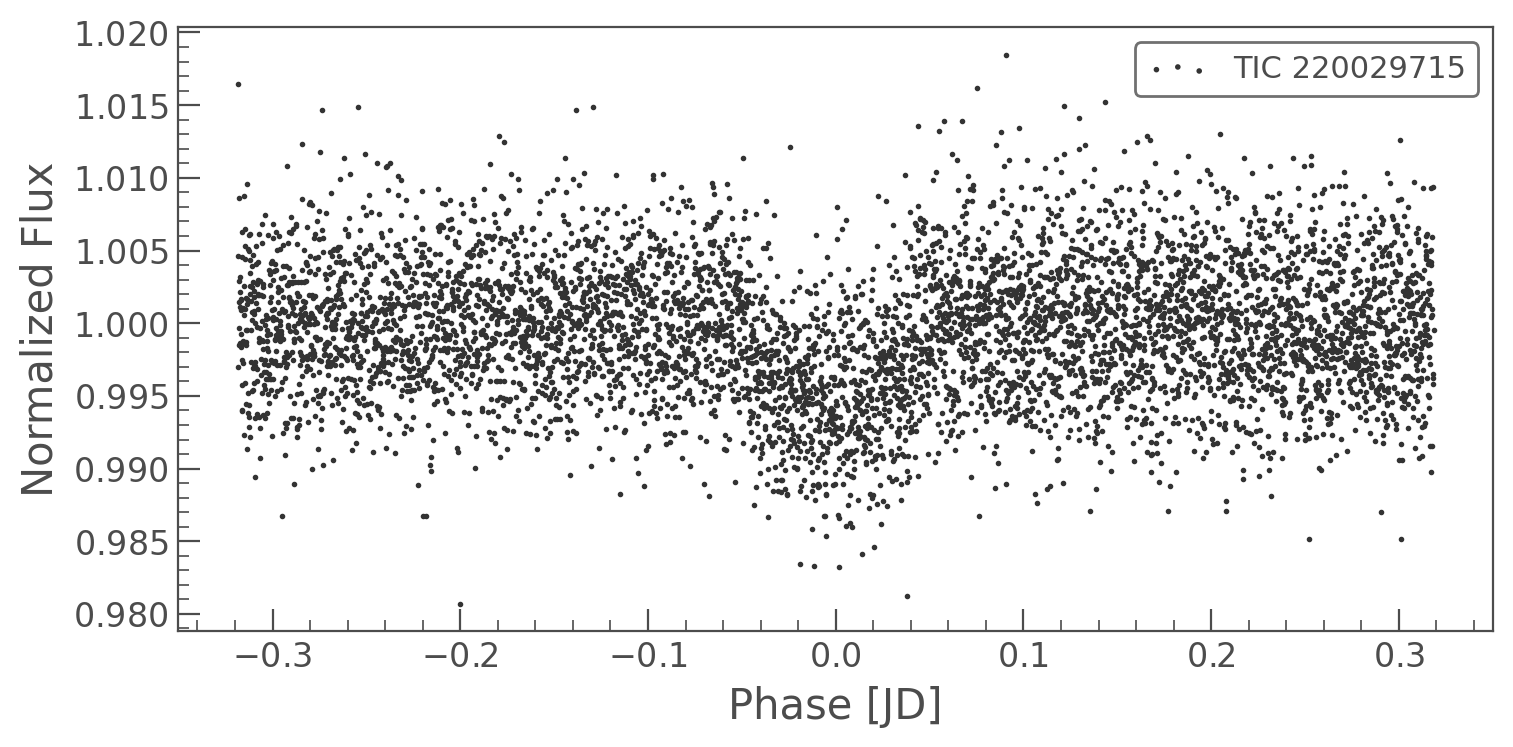

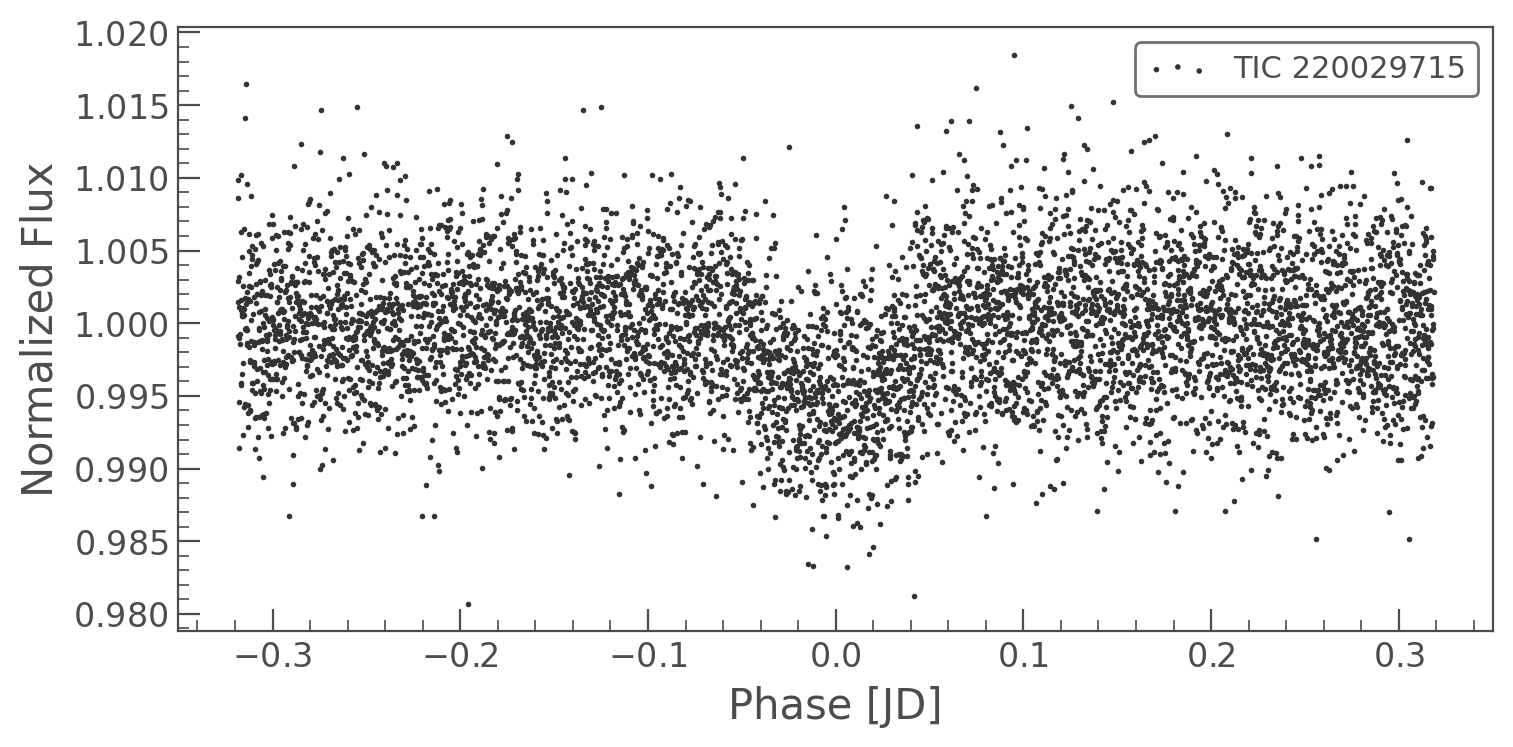

In [7]:
k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()

bls = clc.to_periodogram('bls', minimum_period=obs.period * 0.99, maximum_period=obs.period * 1.01, duration=obs.duration/24, frequency_factor=10)
obs.period, obs.t0 = bls.period_at_max_power.value, bls.transit_time_at_max_power.value + 2457000

k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()

In [8]:
obs.fit_transit(fit_t0=True, fit_period=True, fit_inc=False)

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

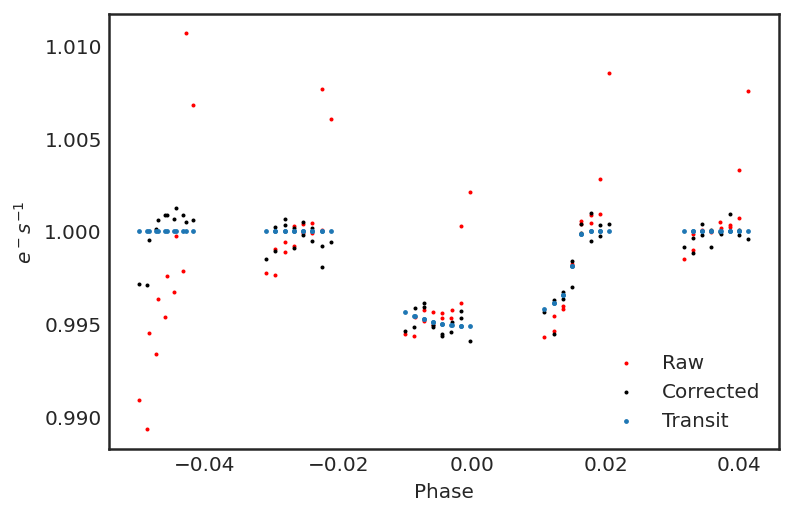

In [9]:
obs.plot()

In [10]:
obs.fit_model()

Fitting Transit/Eclipse Model: 100%|██████████████| 2/2 [00:12<00:00,  6.44s/it]


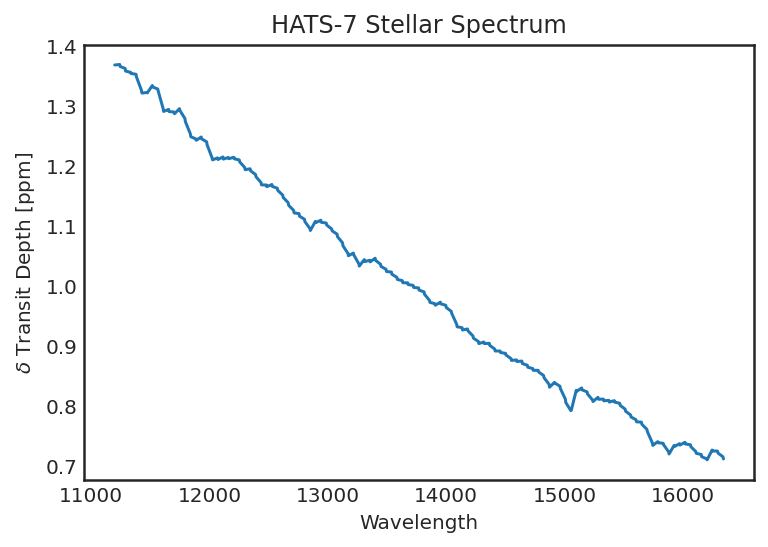

In [11]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

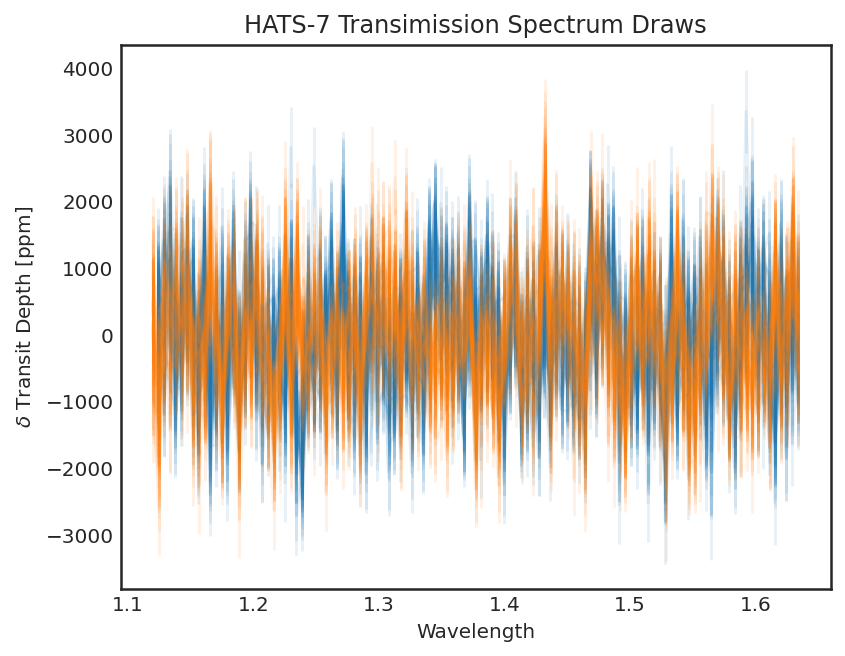

In [12]:
obs.plot_spectra()

[Text(0.5, 1.0, 'WASP-107 Transmission Spectrum')]

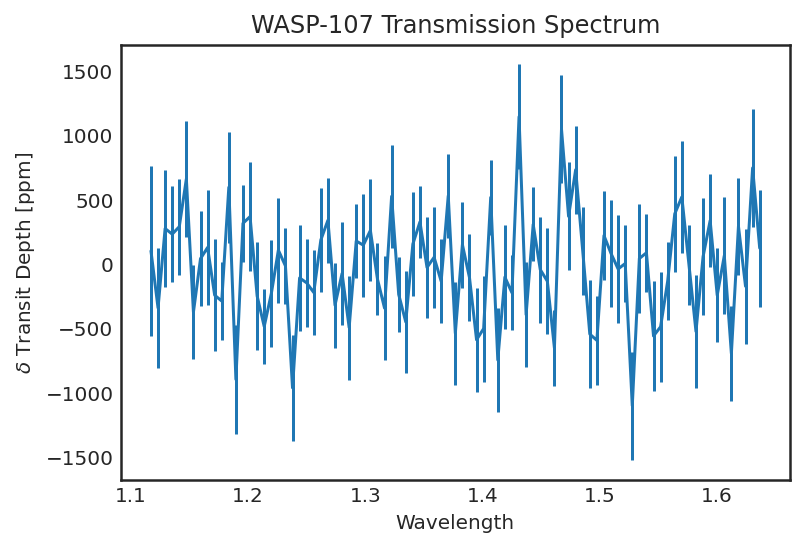

In [13]:
ax = om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 150)).plot()
ax.set(title='WASP-107 Transmission Spectrum')

In [14]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits')
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits')
except:
    pass

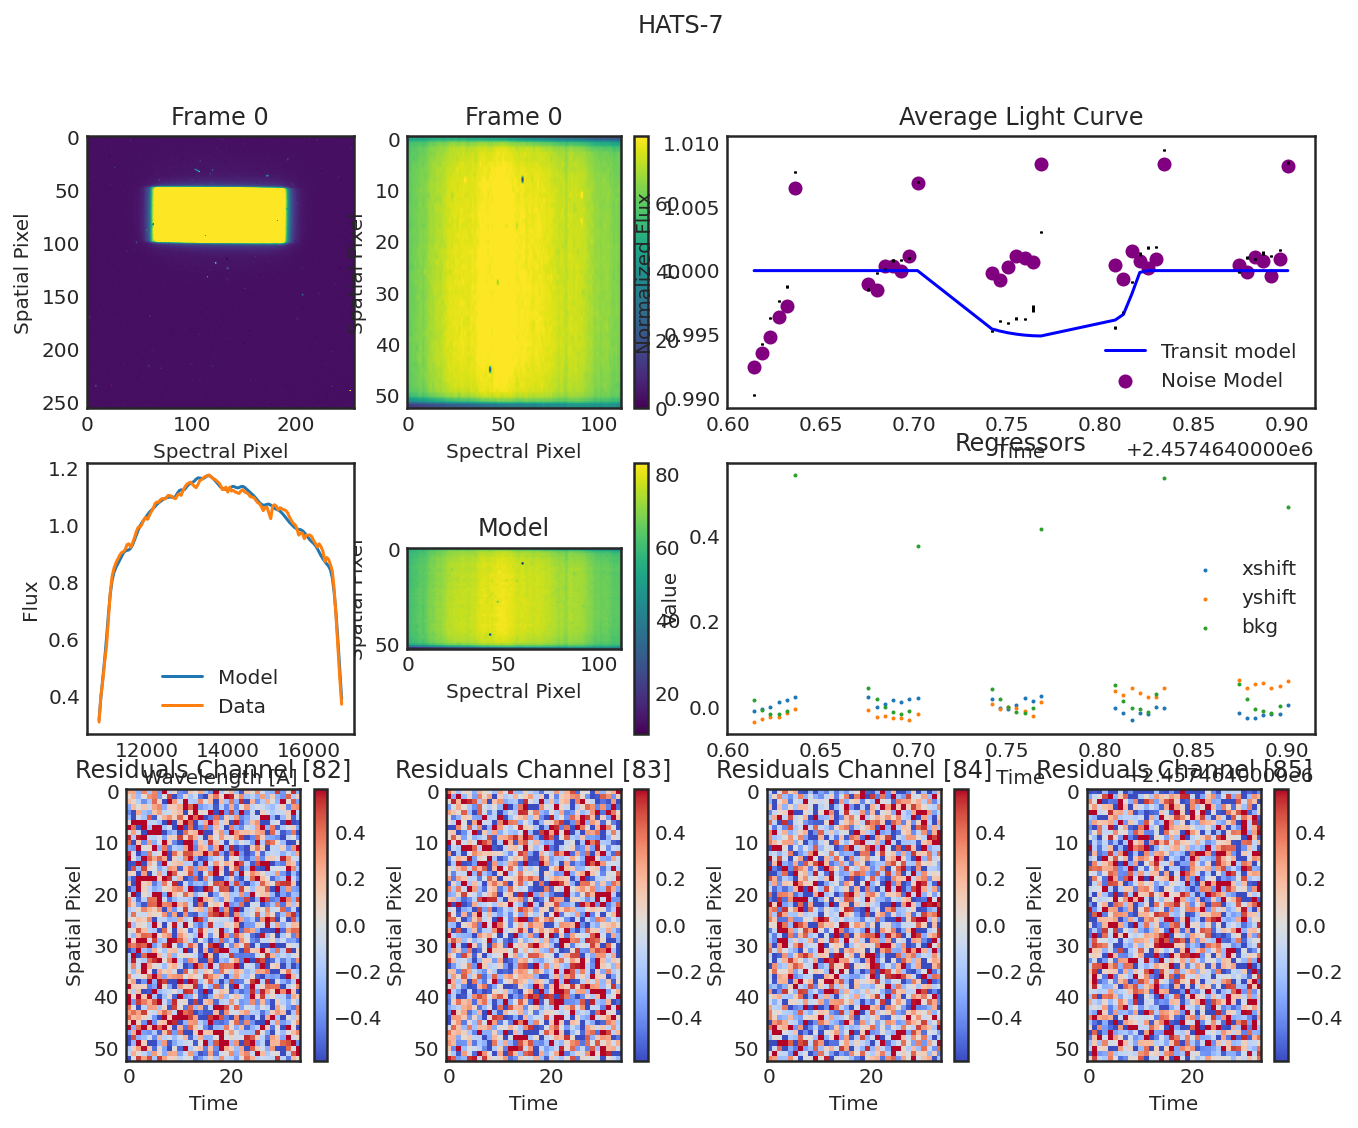

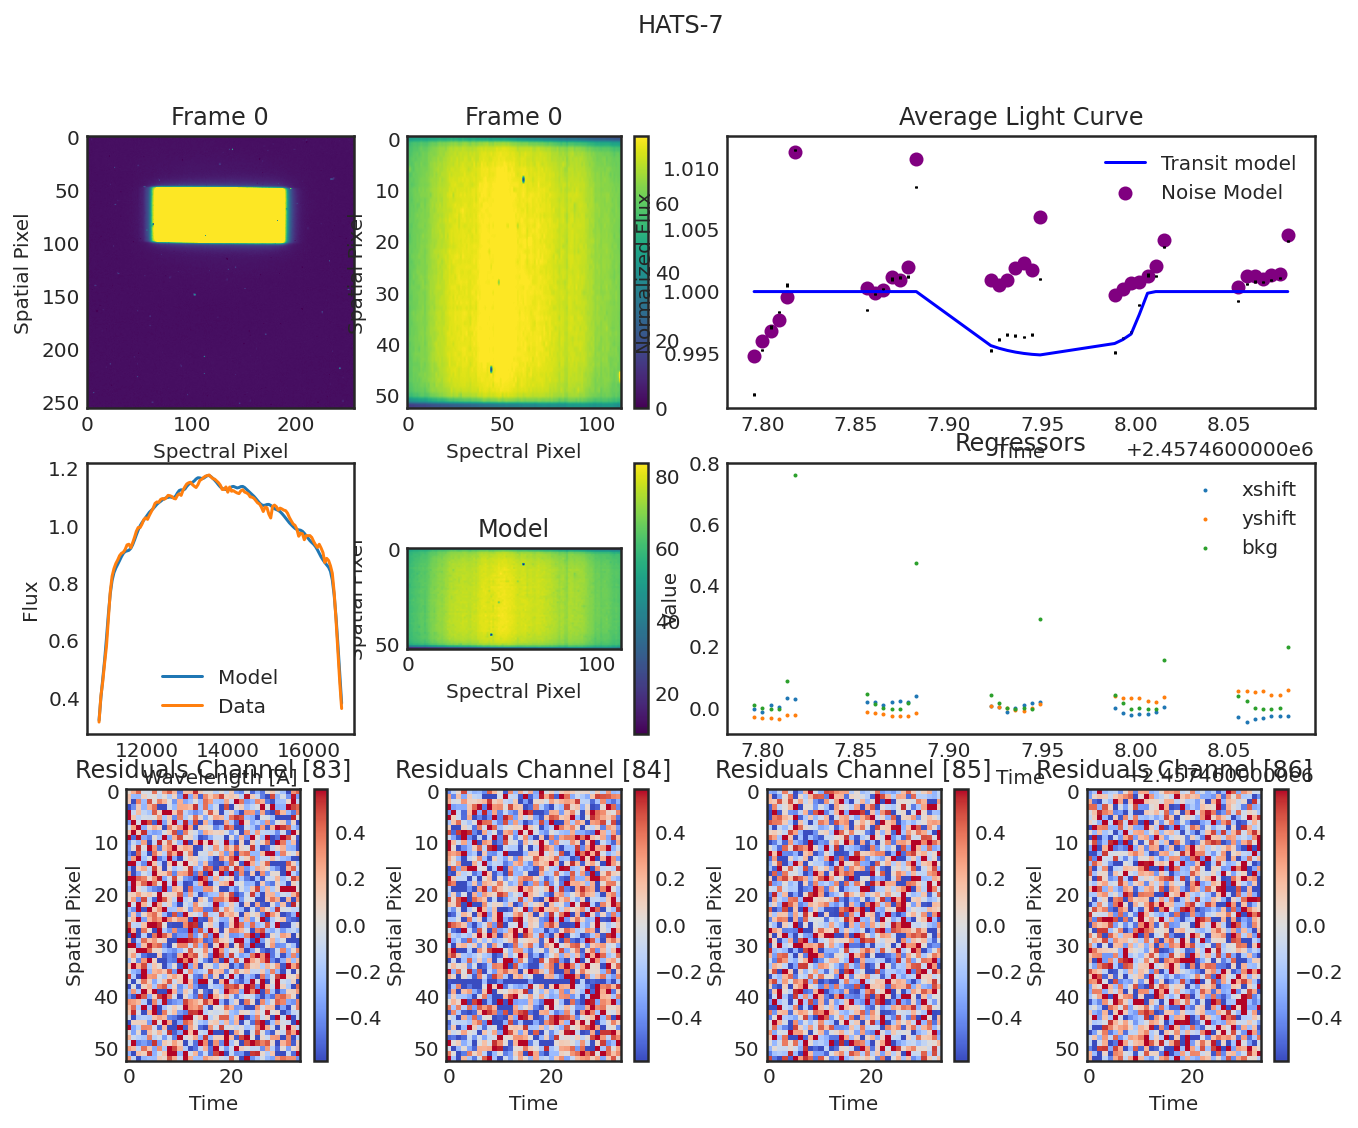

In [15]:
for visit in obs:
    visit.diagnose();
    plt.show();